# Text Classification Assessment

This assessment is a text classification project where the goal is to classify the genre of a movie based on its characteristics, primarily the text of the plot summarization. You have a training set of data that you will use to identify and create your best predicting model. Then you will use that model to predict the classes of the test set of data. We will compare the performance of your predictions to your classmates using the F1 Score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

The **movie_train.csv** dataset contains information (`Release Year`, `Title`, `Plot`, `Director`, `Cast`) about 10,682 movies and the label of `Genre`. There are 9 different genres in this data set, so this is a multiclass problem. You are expected to primarily use the plot column, but can use the additional columns as you see fit.

After you have identified yoru best performing model, you will create predictions for the test set of data. The test set of data, contains 3,561 movies with all of their information except the `Genre`. 

Below is a list of tasks that you will definitely want to complete for this challenge, but this list is not exhaustive. It does not include any tasds around handling class imbalance or about how to test multiple different models and their tuning parameters, but you should still look at doing those to see if they help you to create a better predictive model.


# Good Luck

In [ ]:
# data cleaning and plotting libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

In [2]:
#nltk libraries

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [4]:
# kera libraries

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

Using TensorFlow backend.


In [6]:
#plotly libraries

In [7]:
from chart_studio.plotly import iplot
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [8]:
# sklearn libraries

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer #tfidf
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier #bagging and randomforest
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm #svm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

In [11]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier

In [38]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

### Task #1: Perform imports and load the dataset into a pandas DataFrame


In [12]:
import pandas as pd
train = pd.read_csv('movie_train.csv')

In [13]:
test = pd.read_csv('movie_test.csv', index_col = 0)

### Task #2: Check for missing values:

In [14]:
def print_plot(index):
    example = train[train.index == index][['Plot', 'Plot']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Plot:', example[1])

In [15]:
#print_plot(10)


### Task #3: Remove NaN values:

In [16]:
# Check for NaN values:
train.isnull().sum().sum()

169

In [17]:
# Check for whitespace strings (it's OK if there aren't any!):
import string
def contains_whitespace(s):
    return True in [c in s for c in string.whitespace]
contains_whitespace(train['Plot'])

False

In [18]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    return text

In [19]:
train['cleanplot'] = train['Plot'].apply(lambda x: clean_text(x))

In [20]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()


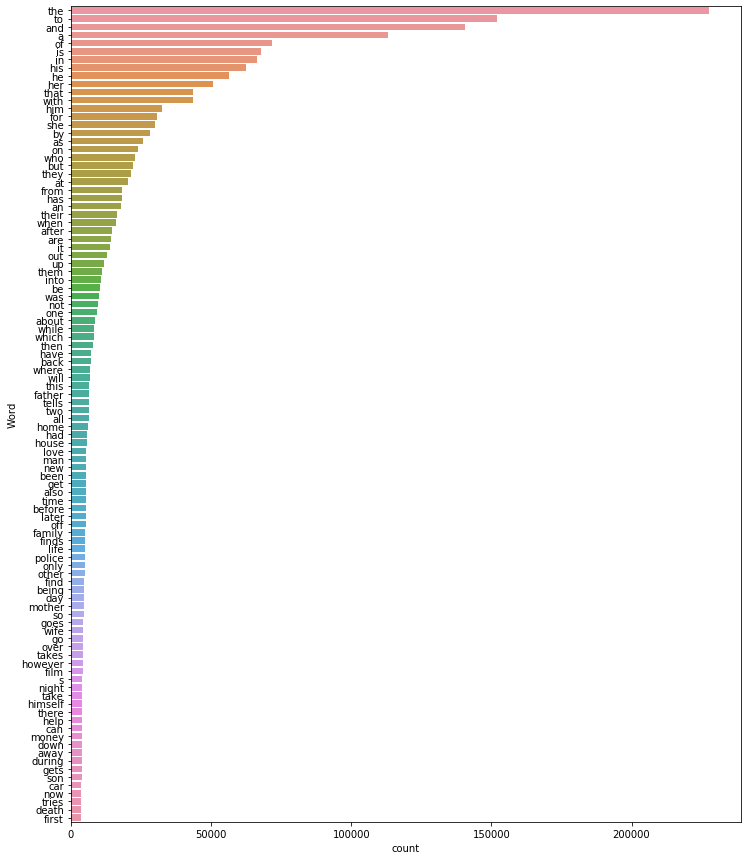

In [21]:
### print 100 most frequent words 
freq_words(train['cleanplot'], 100)

## Remove STOPWORDS

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/zoe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

train['cleanplot'] = train['cleanplot'].apply(lambda x: remove_stopwords(x))

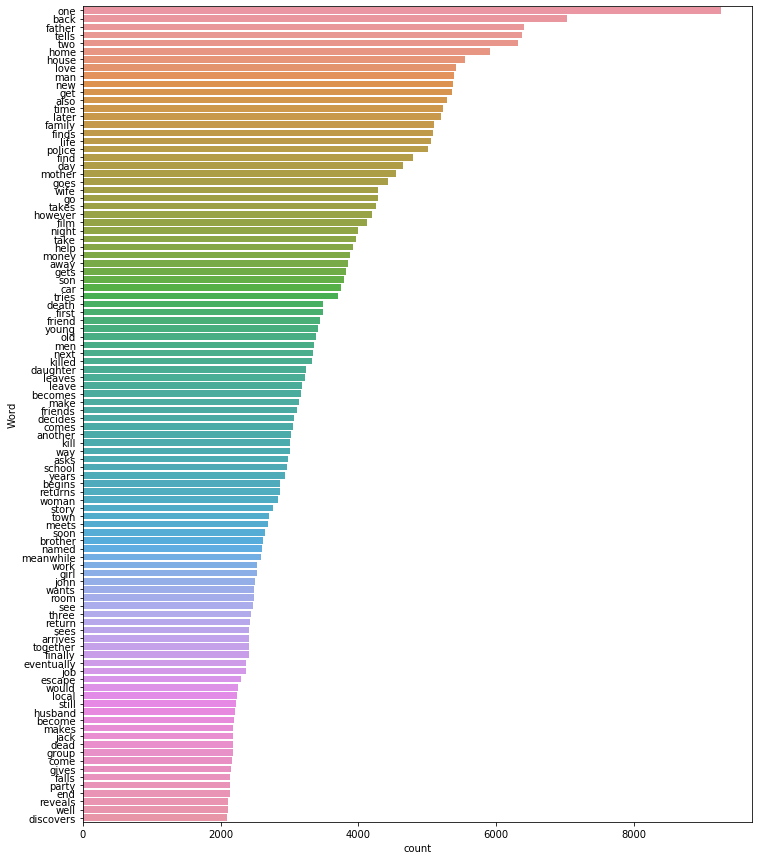

In [25]:
freq_words(train['cleanplot'], 100)

## Functions to compare models

In [26]:
def evaluate(test, pred, model):
    return [model, 
            precision_score(test, pred, average = 'weighted'), 
            recall_score(test, pred,average = 'weighted'), 
            accuracy_score(test, pred), 
            f1_score(test, pred, average = 'weighted')]

In [27]:
def print_accuracy_indices(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average = 'weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds, average = 'weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average = 'weighted')))

## Cleanplot

In [29]:
train['new'] = train.cleanplot + ' ' + train.Director +' '+ train.Title +' '+ train. Title

In [32]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(train['new'])


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [33]:
X = tfidf.transform(train['new'])
train['new'][1]

'lonnie wilson ken scott son sharecropper zuba wilson douglas fowley returns small southern hometown clinton louisiana spending six years chain gang killing colonel ben marquands son davey automobile accident revives love affair melinda marquand martha hyer mrs melinda thomas married dr ned thomas brett halsey lonnie serving time place accident caused somewhat miffed lonnie incites dr ned wifes infidelity dr ned verifies catches lonnie melinda semi torrid embrace colonel marquands hunting lodge melinda looking explanation shoots wounds lonnie defend innocence claiming raped colonel marquand raymond burr bribed lonnie take blame daughter uses story sheriff wheaton kelly thordsen kill lonnie thereby putting end mess mrs marquand joan bennett eventually faces daveys death realizes witnessed melinda run little brother peter marquand jack ging ned return lodge inform otis charges lonnie lies exonerated lonnie gives zuba deed farm old man dances delight thrilled finally land Robert L. Lipper

In [35]:
# transform target variable
train['new_genre'] = pd.factorize(train.Genre)[0]
y = train.new_genre

In [36]:
from imblearn.over_sampling import ADASYN 
sm = ADASYN()
X, y = sm.fit_sample(X, y)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [39]:
start = time.time()
svclassifier = LinearSVC()
svclassifier.fit(X_train, y_train)
svc_runtime = time.time() - start

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [40]:
svcpred = svclassifier.predict(X_test)  

In [41]:
print_accuracy_indices(y_test, svcpred)

Precision Score: 0.925078386775754
Recall Score: 0.9295563549160671
Accuracy Score: 0.9295563549160671
F1 Score: 0.9250916762336727


In [52]:
def plotconfusionmatrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

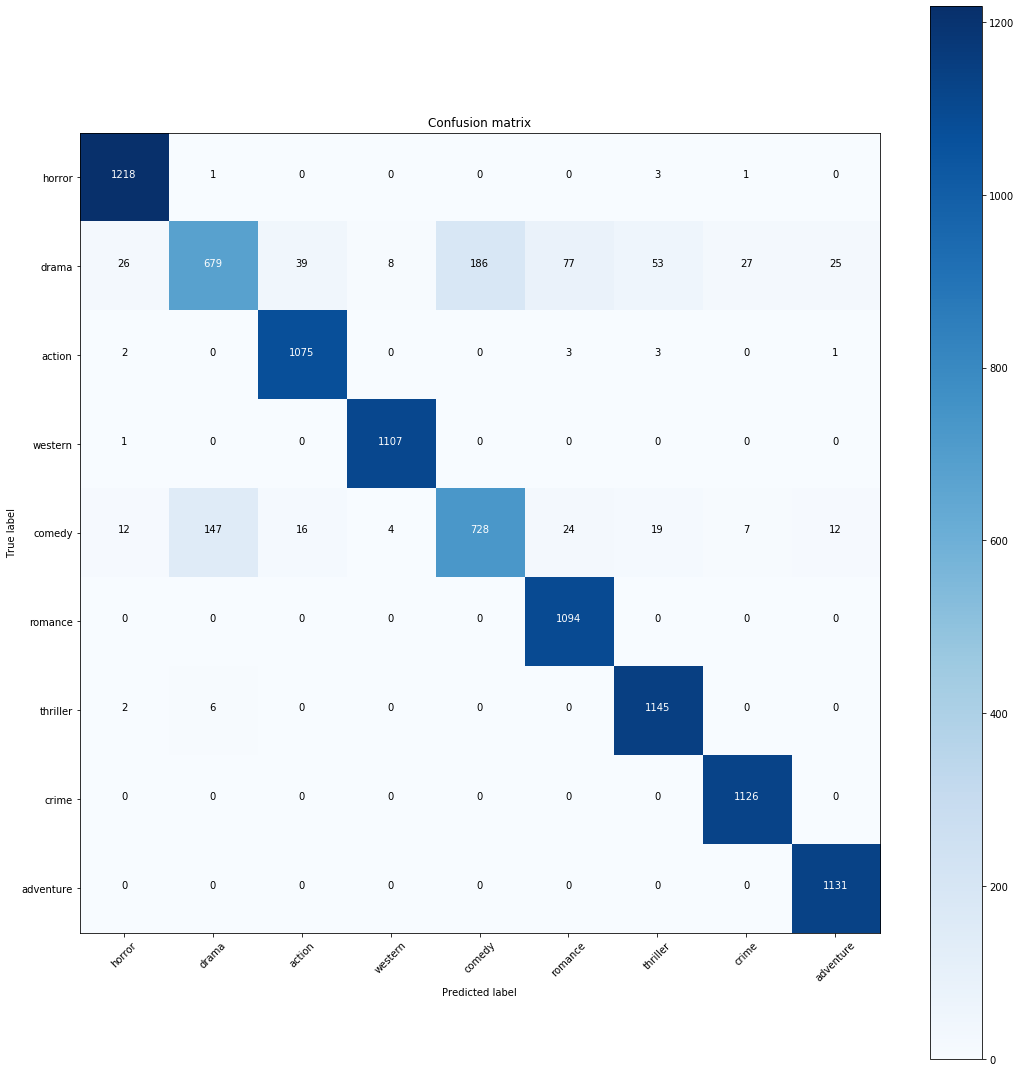

In [53]:
plot_confusion_matrix(confusion_matrix(y_test, svcpred), train.Genre.unique(),
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## NU SVC

In [93]:
start = time.time()
svclassifier = LinearSVC()
svclassifier.fit(X_train, y_train)
svc_runtime = time.time() - start

In [54]:
classifier = Pipeline([('vect',CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',svm.NuSVC(kernel='linear',nu=0.01)),
                        ])

In [55]:
classifier.fit(X_train, y_train)

%time

from sklearn.metrics import classification_report
y_pred = classifier.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=train.Genre.unique()))

AttributeError: lower not found

# KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier


In [51]:
classifier = Pipeline([('vect',CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',KNeighborsClassifier(n_neighbors = 1, n_jobs=1, algorithm='brute', metric='cosine')),
                        ])

In [52]:
classifier.fit(X_train, y_train)

%time

from sklearn.metrics import classification_report
y_pred = classifier.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=train.Genre.unique()))

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                      metric='cosine', metric_params=None,
       

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
accuracy 0.33541341653666146
              precision    recall  f1-score   support

      horror       0.26      0.22      0.24       254
       drama       0.31      0.24      0.27       114
      action       0.40      0.37      0.38       841
     western       0.07      0.05      0.06        95
      comedy       0.42      0.43      0.42      1135
     romance       0.26      0.26      0.26       250
    thriller       0.21      0.27      0.23       177
       crime       0.12      0.15      0.14       205
   adventure       0.30      0.40      0.34       134

    accuracy                           0.34      3205
   macro avg       0.26      0.26      0.26      3205
weighted avg       0.34      0.34      0.34      3205



## Ridge Classifier

In [57]:
from sklearn.linear_model import RidgeClassifier

In [61]:
rc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, 
                                        tol=0.001, class_weight=None, solver='auto', random_state=42)),
               ])
rc.fit(X_train, y_train)

%time

y_pred = rc.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names= train.Genre.unique()))

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True,
                                 fit_intercept=True, max_iter=None,
         

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs
accuracy 0.6078003120124805
              precision    recall  f1-score   support

      horror       0.57      0.36      0.44       254
       drama       0.83      0.35      0.49       114
      action       0.63      0.68      0.65       841
     western       0.40      0.06      0.11        95
      comedy       0.57      0.79      0.66      1135
     romance       0.75      0.71      0.73       250
    thriller       0.51      0.25      0.33       177
       crime       0.31      0.07      0.12       205
   adventure       0.79      0.83      0.81       134

    accuracy                           0.61      3205
   macro avg       0.60      0.46      0.48      3205
weighted avg       0.59      0.61      0.58      3205



## Linear svc

In [454]:
from sklearn.svm import LinearSVC

In [460]:
LVC = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('SVC',  LinearSVC()),
               ])
LVC.fit(X_train, y_train)

%time

y_pred = LVC.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names= train.Genre.unique()))

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('SVC',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                     

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs
accuracy 0.6109204368174727
              precision    recall  f1-score   support

      horror       0.56      0.39      0.46       254
       drama       0.76      0.39      0.51       114
      action       0.64      0.68      0.66       841
     western       0.45      0.14      0.21        95
      comedy       0.58      0.75      0.66      1135
     romance       0.74      0.73      0.74       250
    thriller       0.48      0.27      0.35       177
       crime       0.39      0.15      0.21       205
   adventure       0.75      0.82      0.78       134

    accuracy                           0.61      3205
   macro avg       0.59      0.48      0.51      3205
weighted avg       0.60      0.61      0.59      3205



## RandomForestClassifier

In [ ]:
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['negative','positive']))

In [80]:
RFclassifer = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',  RandomForestClassifier()),
               ])
RFclassifer.fit(X_train, y_train)

%time

y_pred = RFclassifer.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names= train.Genre.unique()))

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

## total words to analyze

In [18]:
train['cleanplot'].apply(lambda x: len(x.split(' '))).sum()

2231816

In [33]:
preds = model.predict(x_test)

In [36]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))


              precision    recall  f1-score   support

           0       0.56      0.41      0.47       189
           1       0.41      0.19      0.26        63
           2       0.57      0.63      0.60       544
           3       0.29      0.03      0.05        67
           4       0.53      0.72      0.61       728
           5       0.66      0.66      0.66       168
           6       0.59      0.24      0.34       139
           7       0.42      0.16      0.23       127
           8       0.71      0.67      0.69       112

    accuracy                           0.56      2137
   macro avg       0.53      0.41      0.44      2137
weighted avg       0.55      0.56      0.54      2137



In [70]:
df = train[pd.notnull(train['new'])]

In [71]:
df['genre_id'] = df['Genre'].factorize()[0]
from io import StringIO
genre_id_df = df[['Genre', 'genre_id']].drop_duplicates().sort_values('genre_id')
genre_to_id = dict(genre_id_df.values)
id_to_genre = dict(genre_id_df[['genre_id', 'Genre']].values)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.cleanplot).toarray()
labels = df.genre_id
features.shape

genre_to_id

(10682, 47420)

{'horror': 0,
 'drama': 1,
 'action': 2,
 'western': 3,
 'comedy': 4,
 'romance': 5,
 'thriller': 6,
 'crime': 7,
 'adventure': 8}

In [72]:
df['genre_id'] = df['Genre'].factorize()[0]
from io import StringIO
genre_id_df = df[['Genre', 'genre_id']].drop_duplicates().sort_values('genre_id')
genre_to_id = dict(genre_id_df.values)
id_to_genre = dict(genre_id_df[['genre_id', 'Genre']].values)

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.cleanplot).toarray()


features.shape

(10682, 47420)

In [74]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Genre, genre_id in sorted(genre_to_id.items()):
    features_chi2 = chi2(features, labels == genre_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Genre))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'action':
  . Most correlated unigrams:
. terrorists
. mithun
  . Most correlated bigrams:
. prakash raj
. martial arts
# 'adventure':
  . Most correlated unigrams:
. pirates
. tarzan
  . Most correlated bigrams:
. west africa
. pirates led
# 'comedy':
  . Most correlated unigrams:
. sach
. comedy
  . Most correlated bigrams:
. bud abbott
. mother riley
# 'crime':
  . Most correlated unigrams:
. hon
. robbery
  . Most correlated bigrams:
. prime suspect
. master criminal
# 'drama':
  . Most correlated unigrams:
. emotional
. kills
  . Most correlated bigrams:
. world war
. year old
# 'horror':
  . Most correlated unigrams:
. creature
. vampire
  . Most correlated bigrams:
. crystal lake
. human flesh
# 'romance':
  . Most correlated unigrams:
. rahul
. love
  . Most correlated bigrams:
. love story
. fall love
# 'thriller':
  . Most correlated unigrams:
. murder
. killer
  . Most correlated bigrams:
. mysteriously murdered
. trunk car
# 'western':
  . Most correlated unigrams:
. catt

### Task #4: Take a look at the columns and do some EDA to familiarize yourself with the data. 

In [16]:
train.Genre.value_counts()

drama        3770
comedy       2724
horror        840
action        830
thriller      685
romance       649
western       525
adventure     331
crime         328
Name: Genre, dtype: int64

In [43]:
train.Genre.value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Genres', 
                                                                title='Movie Genre#')

### Task #5: Split the data into train & test sets:

Yes we have a holdout set of the data, but you do not know the genres of that data, so you can't use it to evaluate your models. Therefore you must create your own training and test sets to evaluate your models. 

### **transform target variables


In [18]:
# transform target variable
train['new_genre'] = pd.factorize(train.Genre)[0]
y = train.new_genre

# Random Forest using Plot only

In [317]:
cvec = CountVectorizer().fit(X_plot)
X_plot = train.cleanplot
y = train.new_genre

In [318]:
# puttheminto dataframe
plot_train = pd.DataFrame(cvec.transform(X_plot).todense(),
                                         columns = cvec.get_feature_names())


In [331]:
# split data into train and testing sets
X_train,X_test,y_train,y_test = train_test_split(plot_train,y, test_size =0.2, random_state =42)

In [332]:
plot_test = pd.DataFrame(cvec.transform(X_test).todense(),
                                         columns = cvec.get_feature_names())

In [78]:
start = time.time()
rfclassifier = RandomForestClassifier(n_estimators=100)
rfclassifier.fit(X_train, y_train)
rf_runtime = time.time() - start

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [82]:
rf_pred = rfclassifier.predict(X_test)  
print_accuracy_indices(y_test, rf_pred)

Precision Score: 0.5563829049705039
Recall Score: 0.48993916705662144
Accuracy Score: 0.48993916705662144
F1 Score: 0.41911568134067906


# Naive Bayes using plot only

In [89]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [90]:
from sklearn.naive_bayes import GaussianNB 
start = time.time()
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
# accuracy on X_test 
accuracy = gnb.score(X_test, y_test) 
nb_runtime = time.time() - start
print (accuracy) 
# creating a confusion matrix 
nbcm = confusion_matrix(y_test, gnb_predictions)

0.37061300889096865


In [92]:
nbcm

array([[ 32,  70,   1,   1,  67,   1,   3,   0,   1],
       [ 22, 404,  24,   6, 246,  37,  18,   5,   5],
       [  5,  82,  20,   1,  43,   9,   3,   2,   1],
       [  0,  42,   2,  13,  31,   0,   1,   2,   1],
       [ 13, 210,  14,   4, 286,  16,  10,   4,   3],
       [  0,  71,   7,   0,  26,   9,   2,   2,   0],
       [  8,  60,   9,   2,  35,   4,  13,   2,   1],
       [  2,  12,   2,   0,  26,   1,   4,   6,   1],
       [  2,  35,   4,   0,  19,   1,   1,   0,   9]])

# RANDOM FOREST USING DIRECTOR ONLY

In [303]:
X_director = train.Director

In [304]:
train.Director = train.Director.str.replace(' ', '')

In [305]:
train.Director.head(20)

0                SimonNuchtern
1              RobertL.Lippert
2                   RobNilsson
3               SunilHingorani
4              RobertRodriguez
5     SouvickSarkarandDipankar
6                    TimWhelan
7                  AlanRudolph
8                  HenryKoster
9               MichaelRitchie
10                      Seeman
11                   KennethBi
12                JohnBoulting
13                HassanAlImam
14               AndrewL.Stone
15               RobertRedford
16                 SrinuVaitla
17                    RingoLam
18                 AlbertLewin
19                GeraldThomas
Name: Director, dtype: object

In [341]:
X= train.Director
y = train.new_genre
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.2, random_state =42)

In [342]:
cvec = CountVectorizer(stop_words = 'english').fit(X_train)
director_train = pd.DataFrame(cvec.transform(X_train).todense(),
                             columns = cvec.get_feature_names())

In [343]:
director_test = pd.DataFrame(cvec.transform(X_test).todense(),
                             columns = cvec.get_feature_names())

In [355]:
y_test

6075     4
3544     1
9290     4
5032     4
2483     1
        ..
9796     1
9870     4
10062    6
8802     2
8617     4
Name: new_genre, Length: 2137, dtype: int64

In [322]:
# puttheminto dataframe
director_train = pd.DataFrame(cvec.transform(train.Director).todense(),
                                         columns = cvec.get_feature_names())


In [349]:
start = time.time()
rfclassifier = RandomForestClassifier(n_estimators=100)
rfclassifier.fit(director_train, y_train)
rf_runtime = time.time() - start

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [356]:
rf_pred = rfclassifier.predict(director_test)  
print_accuracy_indices(y_test, rf_pred)

Precision Score: 0.44617494951355346
Recall Score: 0.4464202152550304
Accuracy Score: 0.4464202152550304
F1 Score: 0.41169463594445205


In [357]:
#Predicting the Test set results
# Making the Confusion Matrix
print(pd.crosstab(y_test, rf_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted   0    1   2   3    4   5   6  7   8
Actual                                        
0          45   94   7   7   10   0   9  2   2
1          13  588   7  33   68  24  20  4  10
2           4   98  32   4   10   6   6  3   3
3           4   36   1  38    8   0   1  1   3
4           6  300   5  11  216   9   6  3   4
5           0   79   9   0    7  18   3  1   0
6           8   89   7   4   10   5   6  4   1
7           0   28   1   4   10   1   3  6   1
8           1   34   4  10   13   0   3  1   5


In [129]:
rf_pred = rfclassifier.predict(x_test)  
print_accuracy_indices(y_test, rf_pred)

Precision Score: 0.41971264825453
Recall Score: 0.4418096723868955
Accuracy Score: 0.4418096723868955
F1 Score: 0.41259198654530577


In [358]:
feature_importances = pd.DataFrame(rfclassifier.feature_importances_,
                                   index = director_train.columns,
                                columns=['importance']).sort_values('importance', ascending=False)

In [359]:
f = feature_importances.head(20)

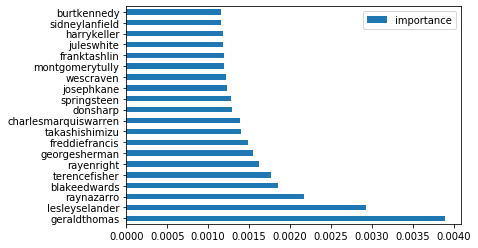

In [360]:
f.plot(kind="barh")

## Bigram using Director

In [97]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import RegexpTokenizer as regextoken
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams, trigrams
from nltk import WordNetLemmatizer

In [295]:
X = train['Director'].tolist()

In [175]:
train["cleanplot"] = train["cleanplot"].apply(lambda x: x.lower())

In [177]:
tokenizer = regextoken("[a-zA-Z]+") 

In [179]:
# These are common words that typically don't add meaning to the text and can be removed
stop = stopwords.words("english")
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [180]:
# Tokenizing the text
tokens = train["cleanplot"].apply(tokenizer.tokenize) 
# Removing stopwords 
tokens = tokens.apply(lambda x: [token for token in x if token not in stop])

In [469]:
# Writing a function to lemmatize words
lmtzr = WordNetLemmatizer()
def lem(text):
    return [lmtzr.lemmatize(word) for word in text]

# Applying the function to each row of the text
# i.e. reducing each word to its lemma
tokens_new = tokens.apply(lem)

In [167]:
import re

def generate_ngrams(s, n):
    # Convert to lowercases
    s = s.lower()
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [184]:
all_reviews = tokens.astype(str).str.cat()

In [185]:
cleaned_reviews = tokenizer.tokenize(all_reviews)

In [187]:
# Getting the frequency distribution of individual words in the reviews
fd = FreqDist()
for word in cleaned_reviews:
    fd[word] += 1
    
# Examining the top 5 most frequent words
fd.most_common(5)

[('one', 9260),
 ('back', 7029),
 ('father', 6413),
 ('tells', 6374),
 ('two', 6318)]

<Figure size 720x360 with 0 Axes>

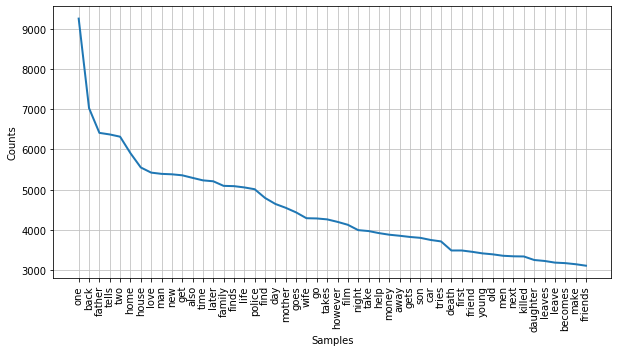

In [192]:
# Plotting the top 50 most frequent words
plt.figure(figsize = (10, 5))
fd.plot(50)
plt.show()

In [367]:
tokens[0]

['computer',
 'error',
 'leads',
 'accidental',
 'release',
 'homicidal',
 'patient',
 'howard',
 'johns',
 'mental',
 'institution',
 'mute',
 'murderer',
 'returns',
 'scene',
 'original',
 'crimes']

In [369]:
from nltk.util import ngrams


In [372]:
bigrams = tokens.apply(lambda x : list(nltk.ngrams(x, 2)))


In [375]:
bigrams

0        [(computer, error), (error, leads), (leads, ac...
1        [(lonnie, wilson), (wilson, ken), (ken, scott)...
2        [(gaunt, bushy), (bushy, bearded), (bearded, y...
3        [(ram, avtar), (avtar, childhood), (childhood,...
4        [(machete, cortez), (cortez, danny), (danny, t...
                               ...                        
10677    [(nick, sanders), (sanders, comes), (comes, ho...
10678    [(film, covers), (covers, first), (first, half...
10679    [(sam, gold), (gold, jesse), (jesse, eisenberg...
10680    [(yankee, lawyer), (lawyer, john), (john, reyn...
10681    [(somewhat, fictionalized), (fictionalized, ac...
Name: cleanplot, Length: 10682, dtype: object

In [373]:
bigrams

0        [(computer, error), (error, leads), (leads, ac...
1        [(lonnie, wilson), (wilson, ken), (ken, scott)...
2        [(gaunt, bushy), (bushy, bearded), (bearded, y...
3        [(ram, avtar), (avtar, childhood), (childhood,...
4        [(machete, cortez), (cortez, danny), (danny, t...
                               ...                        
10677    [(nick, sanders), (sanders, comes), (comes, ho...
10678    [(film, covers), (covers, first), (first, half...
10679    [(sam, gold), (gold, jesse), (jesse, eisenberg...
10680    [(yankee, lawyer), (lawyer, john), (john, reyn...
10681    [(somewhat, fictionalized), (fictionalized, ac...
Name: cleanplot, Length: 10682, dtype: object

# LSTM  recurrent neural network

In [63]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['new'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 84565 unique tokens.


In [64]:
X = tokenizer.texts_to_sequences(train['new'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10682, 100)


In [65]:
Y = pd.get_dummies(train['Genre']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10682, 9)


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [68]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/Users/zoe/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 7690 samples, validate on 855 samples
Epoch 1/5
7690/7690 [==============================] - 15s 2ms/step - loss: 1.8584 - accuracy: 0.3485 - val_loss: 1.8102 - val_accuracy: 0.3450
Epoch 2/5
7690/7690 [==============================] - 17s 2ms/step - loss: 1.5740 - accuracy: 0.4373 - val_loss: 1.5437 - val_accuracy: 0.4725
Epoch 3/5
7690/7690 [==============================] - 18s 2ms/step - loss: 1.2173 - accuracy: 0.5793 - val_loss: 1.4838 - val_accuracy: 0.4959
Epoch 4/5
7690/7690 [==============================] - 18s 2ms/step - loss: 0.9896 - accuracy: 0.6603 - val_loss: 1.5525 - val_accuracy: 0.4924
Epoch 5/5
7690/7690 [==============================] - 18s 2ms/step - loss: 0.8328 - accuracy: 0.7191 - val_loss: 1.6149 - val_accuracy: 0.4772


In [46]:
from sklearn.metrics import confusion_matrix
import itertools

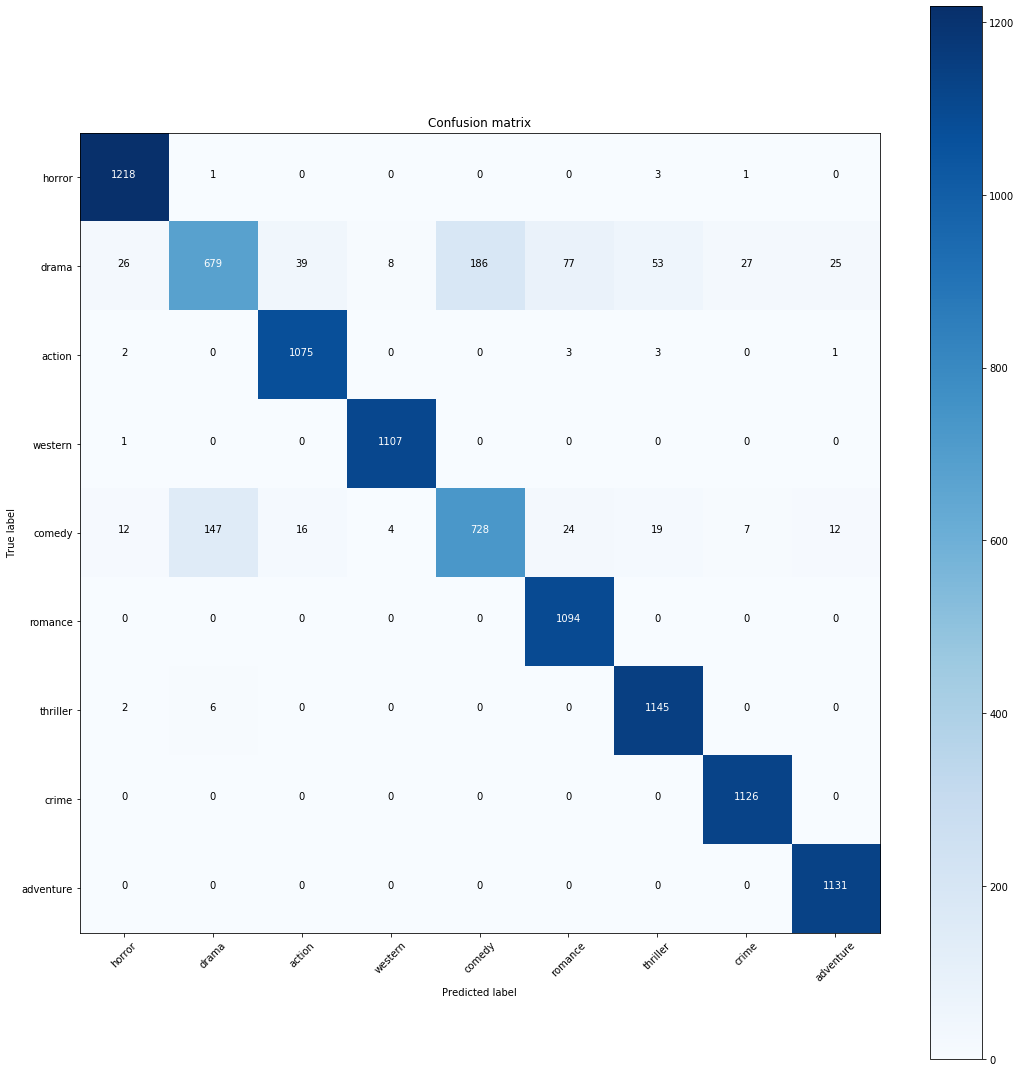

In [51]:
plot_confusion_matrix(confusion_matrix(y_test, svcpred), train.Genre.unique(),
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
for label in ax.get_xticklabels():
    label.set_fontsize(15) 
    label.set_ha("right")
    label.set_rotation(45)

for label in ax.get_yticklabels():
    label.set_fontsize(15)

### bag of words with Keras

In [468]:
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(train) * .7)
train_posts = train['new'][:train_size]
train_tags = train['Genre'][:train_size]

test_posts = train['new'][train_size:]
test_tags = train['Genre'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 64
epochs = 5

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

LabelEncoder()

Train on 6729 samples, validate on 748 samples
Epoch 1/5
6729/6729 [==============================] - 1s 131us/step - loss: 1.5558 - accuracy: 0.4562 - val_loss: 1.3329 - val_accuracy: 0.5321
Epoch 2/5
6729/6729 [==============================] - 1s 85us/step - loss: 1.0806 - accuracy: 0.6138 - val_loss: 1.2825 - val_accuracy: 0.5481
Epoch 3/5
6729/6729 [==============================] - 1s 93us/step - loss: 0.8729 - accuracy: 0.6934 - val_loss: 1.2705 - val_accuracy: 0.5602
Epoch 4/5
6729/6729 [==============================] - 1s 102us/step - loss: 0.7279 - accuracy: 0.7497 - val_loss: 1.2874 - val_accuracy: 0.5548
Epoch 5/5
6729/6729 [==============================] - 1s 90us/step - loss: 0.5950 - accuracy: 0.8052 - val_loss: 1.3266 - val_accuracy: 0.5561


### Task #6: Build a pipeline to vectorize the date, then train and fit your models.
You should train multiple types of models and try different combinations of the tuning parameters for each model to obtain the best one. You can use the SKlearn functions of GridSearchCV and Pipeline to help automate this process.


### Task #7: Run predictions and analyze the results on the test set to identify the best model.  

In [ ]:
## traditional plotting

Text(0.5, 0, 'Predicted')

Text(0, 0.5, 'Actual')

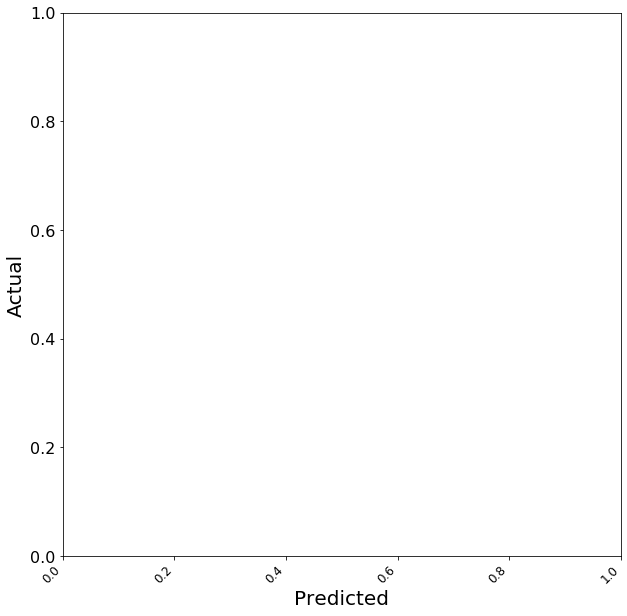

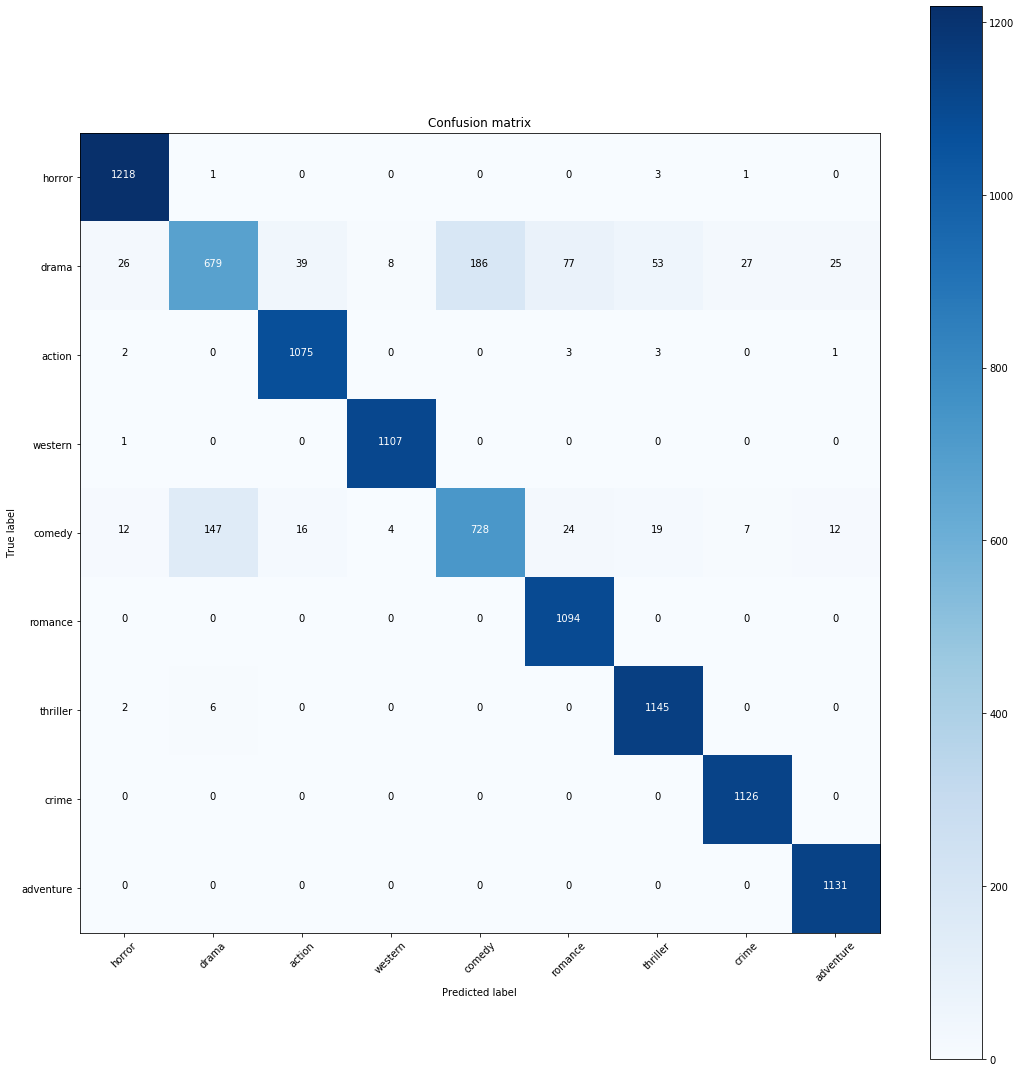

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(confusion_matrix(y_test, svcpred), train.Genre.unique(),
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Actual", fontsize=20)
for label in ax.get_xticklabels():
    label.set_fontsize(12) 
    label.set_ha("right")
    label.set_rotation(45)

for label in ax.get_yticklabels():
    label.set_fontsize(16)

In [ ]:
# Form a prediction set


In [ ]:
# Report the confusion matrix



In [ ]:
# Print a classification report


In [ ]:
# Print the overall accuracy and F1 score


### Task #8: Refit the model to all of your data and then use that model to predict the holdout set. 

### #9: Save your predictions as a csv file that you will send to the instructional staff for evaluation. 

## Great job!